<a href="https://colab.research.google.com/github/rvsvhy/Machine-Learning/blob/main/Machine_Learning_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files

# Upload a file
uploaded = files.upload()

# Check uploaded file names
for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")


Saving Combined_MalMem.csv to Combined_MalMem.csv
Uploaded file: Combined_MalMem.csv


Class Spreads:
 {'Spyware': pslist.nproc                                 7.839263
pslist.nppid                                 3.494419
pslist.avg_threads                           2.384983
pslist.avg_handlers                         27.132259
dlllist.ndlls                              253.864164
dlllist.avg_dlls_per_proc                    3.075121
handles.nhandles                          1317.224614
handles.avg_handles_per_proc                26.114655
handles.nfile                              141.150149
handles.nevent                             530.807427
handles.ndesktop                             8.112339
handles.nkey                               141.133793
handles.nthread                             87.912895
handles.ndirectory                          15.994855
handles.nsemaphore                         104.115053
handles.ntimer                              14.508827
handles.nsection                            43.421094
handles.nmutant                             34.738962


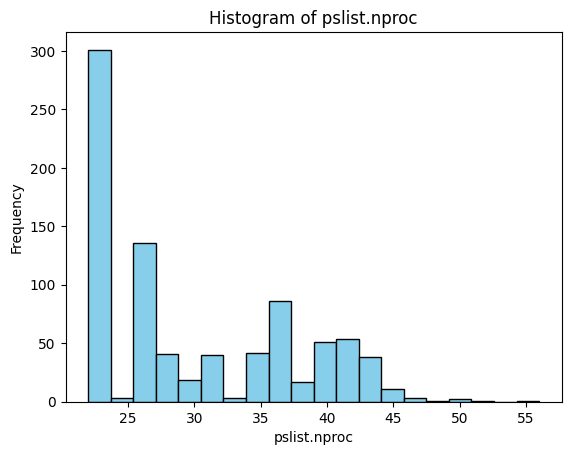


Feature: pslist.nproc, Mean: 30.023529411764706, Variance: 60.541259613386224


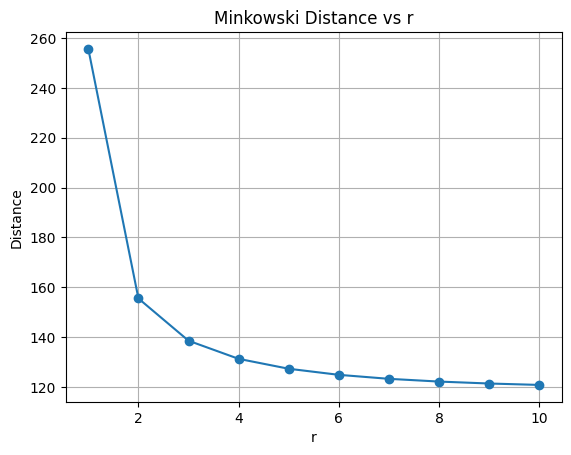


Minkowski Distances (r=1 to 10): [np.float64(255.6390607317993), 155.4695101859898, np.float64(138.50650314680735), np.float64(131.23396463617593), np.float64(127.25668926061822), np.float64(124.81662277464935), np.float64(123.21383799781913), np.float64(122.11281302261659), np.float64(121.33255390712156), np.float64(120.76699117944767)]

Test Accuracy (k=3): 0.48

Predictions (first 10): [0 0 1 0 1 0 1 1 0 0]
Prediction for first test vector: [0]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


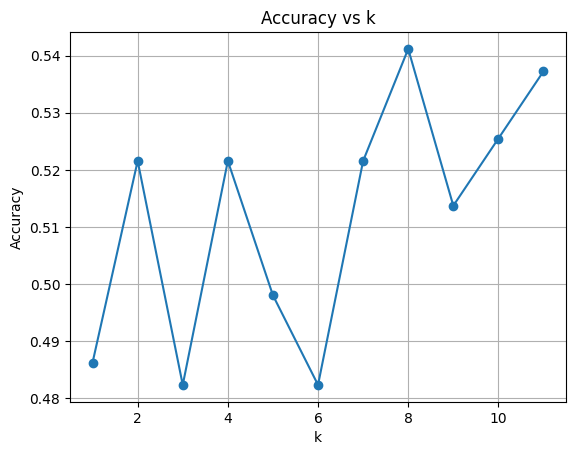


Accuracies for k=1 to 11: [0.48627450980392156, 0.5215686274509804, 0.4823529411764706, 0.5215686274509804, 0.4980392156862745, 0.4823529411764706, 0.5215686274509804, 0.5411764705882353, 0.5137254901960784, 0.5254901960784314, 0.5372549019607843]

Confusion Matrix:
 [[69 63]
 [69 54]]
Precision: 0.46, Recall: 0.44, F1 Score: 0.45
Train Accuracy: 0.78, Test Accuracy: 0.48
Model Status: Overfitting


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from scipy.spatial import distance

# ---------------------------
# Load and preprocess dataset
# ---------------------------
def load_dataset(csv_file):
    df = pd.read_csv(csv_file)
    df = df.drop(columns=["Filename"], errors='ignore')
    df = df.loc[:, df.nunique() > 1]  # Drop constant features

    # Ensure only two classes are used (Spyware & Benign)
    if 'Class' not in df.columns:
        np.random.seed(42)
        df['Class'] = np.random.choice(['Spyware', 'Benign'], size=len(df))
    df = df[df['Class'].isin(['Spyware', 'Benign'])]

    X = df.drop(columns=['Class'])
    y = df['Class'].astype('category').cat.codes  # Convert to numeric
    return X, y, df['Class']

# ---------------------------
# A1: Intraclass spread & Interclass distance
# ---------------------------
def calculate_spread_and_distance(X, y_labels):
    classes = y_labels.unique()
    centroids = {}
    spreads = {}

    for cls in classes:
        class_vectors = X[y_labels == cls]
        centroids[cls] = class_vectors.mean(axis=0)
        spreads[cls] = class_vectors.std(axis=0)

    interclass_distance = np.linalg.norm(centroids[classes[0]] - centroids[classes[1]])
    return spreads, interclass_distance

# ---------------------------
# A2: Feature histogram, mean & variance
# ---------------------------
def feature_histogram_stats(X, feature_index=0):
    feature_name = X.columns[feature_index]
    feature_data = X[feature_name]

    plt.hist(feature_data, bins=20, color='skyblue', edgecolor='black')
    plt.title(f"Histogram of {feature_name}")
    plt.xlabel(feature_name)
    plt.ylabel("Frequency")
    plt.show()

    return feature_name, feature_data.mean(), feature_data.var()

# ---------------------------
# A3: Minkowski distance
# ---------------------------
def minkowski_distance_plot(X):
    vec1 = X.iloc[0]
    vec2 = X.iloc[1]
    r_values = range(1, 11)
    distances = [distance.minkowski(vec1, vec2, r) for r in r_values]

    plt.plot(r_values, distances, marker='o')
    plt.title("Minkowski Distance vs r")
    plt.xlabel("r")
    plt.ylabel("Distance")
    plt.grid(True)
    plt.show()

    return distances

# ---------------------------
# A4: Train-test split
# ---------------------------
def split_dataset(X, y):
    return train_test_split(X, y, test_size=0.3, random_state=42)

# ---------------------------
# A5 & A6: Train & evaluate kNN (k=3)
# ---------------------------
def train_evaluate_knn(X_train, y_train, X_test, y_test, k=3):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    accuracy = knn.score(X_test, y_test)
    return knn, accuracy

# ---------------------------
# A7: Predict test vectors
# ---------------------------
def predict_test_samples(knn, X_test):
    return knn.predict(X_test), knn.predict([X_test.iloc[0]])

# ---------------------------
# A8: Accuracy vs k plot
# ---------------------------
def plot_accuracy_vs_k(X_train, y_train, X_test, y_test):
    k_values = range(1, 12)
    accuracies = []
    for k in k_values:
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)
        accuracies.append(model.score(X_test, y_test))

    plt.plot(k_values, accuracies, marker='o')
    plt.title("Accuracy vs k")
    plt.xlabel("k")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()

    return accuracies

# ---------------------------
# A9: Confusion matrix & metrics
# ---------------------------
def evaluate_model(knn, X_test, y_test):
    y_pred = knn.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    train_acc = knn.score(X_train, y_train)
    test_acc = knn.score(X_test, y_test)

    # Determine fit type
    if train_acc > test_acc + 0.1:
        fit_status = "Overfitting"
    elif abs(train_acc - test_acc) < 0.05:
        fit_status = "Regular fitting"
    else:
        fit_status = "Underfitting"

    return cm, precision, recall, f1, train_acc, test_acc, fit_status

# ---------------------------
# Main Program
# ---------------------------
if __name__ == "__main__":
    # Load dataset
    X, y, y_labels = load_dataset("Combined_MalMem.csv")

    # A1
    spreads, interclass_distance = calculate_spread_and_distance(X, y_labels)
    print("Class Spreads:\n", spreads)
    print("\nInterclass Distance:", interclass_distance)

    # A2
    feature_name, mean_feature, var_feature = feature_histogram_stats(X)
    print(f"\nFeature: {feature_name}, Mean: {mean_feature}, Variance: {var_feature}")

    # A3
    minkowski_distances = minkowski_distance_plot(X)
    print("\nMinkowski Distances (r=1 to 10):", minkowski_distances)

    # A4
    X_train, X_test, y_train, y_test = split_dataset(X, y)

    # A5 & A6
    knn, test_accuracy = train_evaluate_knn(X_train, y_train, X_test, y_test)
    print(f"\nTest Accuracy (k=3): {test_accuracy:.2f}")

    # A7
    predictions, single_prediction = predict_test_samples(knn, X_test)
    print("\nPredictions (first 10):", predictions[:10])
    print("Prediction for first test vector:", single_prediction)

    # A8
    accuracies = plot_accuracy_vs_k(X_train, y_train, X_test, y_test)
    print("\nAccuracies for k=1 to 11:", accuracies)

    # A9
    cm, precision, recall, f1, train_acc, test_acc, fit_status = evaluate_model(knn, X_test, y_test)
    print("\nConfusion Matrix:\n", cm)
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")
    print(f"Train Accuracy: {train_acc:.2f}, Test Accuracy: {test_acc:.2f}")
    print(f"Model Status: {fit_status}")
